# Reviews Text Extractor
This notebook is used downstream to the scraping algorithm to extract the text of the reviews from the `html` bodies.

In [172]:
import json
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [173]:
def clean_reviews(html: str) -> list[dict[str, str]]:
    soup = BeautifulSoup(html, "html.parser")
    titles = []
    contents = []
    dates = []

    # Extract the titles
    for a in soup.find_all("a", class_="review-title-content"):
        span_tags = a.find_all("span")
        titles.append(span_tags[2].get_text(strip=True)
                      if len(span_tags) >= 3 else '')

    # Extract the content
    for span in soup.find_all("span", class_="review-text-content"):
        span_tags = span.find_all("span")
        contents.append(span_tags[0].get_text(
            strip=True) if len(span_tags) >= 1 else '')

    # Extract the date
    for span in soup.find_all("span", class_="review-date"):
        dates.append(span.get_text(strip=True).split('on ')[1])

    return [{'title': t, 'content': c, 'date': d} for t, c, d in zip(titles, contents, dates)]

In [174]:
reviews_raw={}
with open('reviews_raw.json') as f:
    reviews_raw = json.load(f)

In [175]:
df = pd.DataFrame([
    {
        'stars': key.split(':')[0],
        'timestamp': review['date'],
        'title': review['title'],
        'content': review['content']
    }
    for key, html in reviews_raw.items()
    for review in clean_reviews(html)
])
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [176]:
df.head()

,stars,timestamp,title,content
0,1,2024-01-08,Terrible,I've had my printer for a year. It stopped wor...
1,1,2024-12-19,Instant ink is a JOKE,I will never purchase another HP product again...
2,1,2024-09-10,Avoid,The printer itself is decent. HP promotes thei...
3,1,2024-12-30,a bit suspicious of the 3 month ink supply,I've had a series of errors with the printer w...
4,1,2024-11-05,"If you want to waste time, buy this one!","This printer frequently ""resets"" itself and no..."


In [177]:
df.to_csv('reviews_clean.csv')

In [178]:
df = pd.read_csv('reviews_clean.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values('timestamp')
pass

In [179]:
def aggregate_stars(period='M') -> pd.DataFrame:
    df['number_of_reviews'] = 1
    df['star_1'] = df['stars'].apply(lambda x: 1 if x == 1 else 0)
    df['star_2'] = df['stars'].apply(lambda x: 1 if x == 2 else 0)
    df['star_3'] = df['stars'].apply(lambda x: 1 if x == 3 else 0)
    df['star_4'] = df['stars'].apply(lambda x: 1 if x == 4 else 0)
    df['star_5'] = df['stars'].apply(lambda x: 1 if x == 5 else 0)
    aggregated_df = (
        df.groupby(df['timestamp'].dt.to_period(period))[
            ['stars', 'star_1', 'star_2', 'star_3', 'star_4', 'star_5', 'number_of_reviews']]
        .sum()
        .reset_index()
        .rename({'timestamp': 'period'}, axis="columns")
    )
    aggregated_df['end_timestamp'] = aggregated_df['period'].dt.end_time
    return aggregated_df

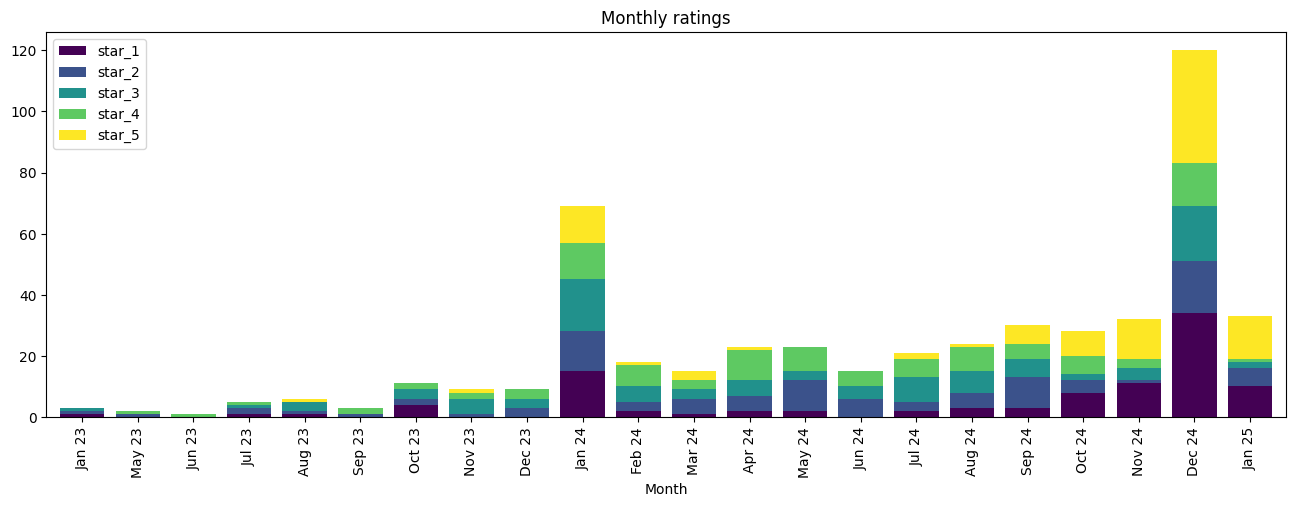

In [180]:
monthly_df = aggregate_stars(
    'M')[['end_timestamp', 'star_1', 'star_2', 'star_3', 'star_4', 'star_5']]
ax = monthly_df.plot(
    kind='bar', x='end_timestamp', stacked=True, figsize=(16, 5), colormap='viridis', width=.8)
ax.set_xticklabels([d.strftime('%b %y') for d in monthly_df['end_timestamp']])
ax.set_xlabel('Month')
ax.set_title('Monthly ratings')
plt.show()

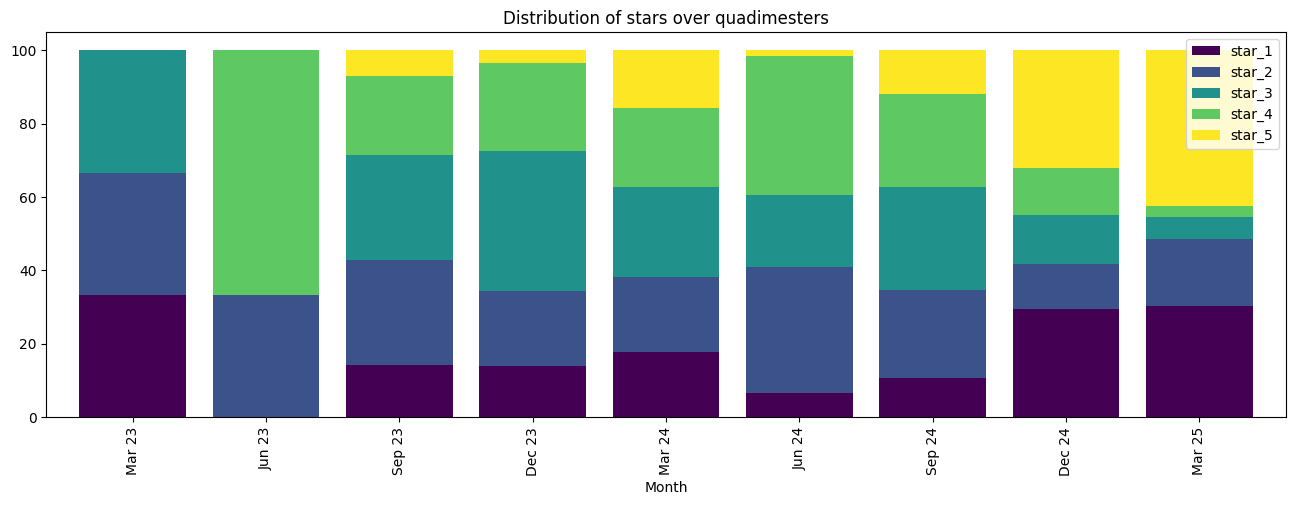

In [181]:
monthly_df = aggregate_stars(
    'Q')[['end_timestamp', 'star_1', 'star_2', 'star_3', 'star_4', 'star_5']]
df_percent = monthly_df.drop(columns=['end_timestamp']).div(
    monthly_df.drop(columns=['end_timestamp']).sum(axis=1), axis=0) * 100
df_percent['end_timestamp'] = monthly_df['end_timestamp']

ax = df_percent.plot(
    kind='bar', x='end_timestamp', stacked=True, figsize=(16, 5), colormap='viridis', width=.8)
ax.set_xticklabels([d.strftime('%b %y')
                   for d in df_percent['end_timestamp']])

ax.set_xlabel('Month')
ax.set_title('Distribution of stars over quadimesters')
plt.show()